In [ ]:
#Libraries
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt

#NLP

##Facebook

In [ ]:
##NLP --------------

#Importing libs
import numpy as np
import seaborn as sns
sns.set()

In [ ]:
import nltk 
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

In [ ]:
#Installing the libraries needed for spacy, as well as catalan nlp database
!pip install -U pip setuptools wheel
!pip install -U spacy
!python -m spacy download ca_core_news_sm

     |████████████████████████████████| 20.4 MB 2.0 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('ca_core_news_sm')


In [ ]:
import spacy

In [ ]:
#Importing FB data
fb_data_orig = pd.read_csv('/content/fb_labeled.csv')
fb_data_orig['post_id'] = [i for i in range(1,(len(fb_data_orig)+1))]

In [ ]:
#Removing NaNs
fb_data_nlp = fb_data_orig.dropna(subset=['Caption'])

In [ ]:
fb_data_nlp

,Unnamed: 0,Caption,Post time,Reach,Likes and Reactions,Comments,Shares,Results,Cost Per Result,Link Clicks,Unnamed: 9,Hashtag in post (Y/N),Number of hashtags,Hashtags in post,Emoji in post (Y/N),Number of Emojis,Link in post (Y/N),Posted Link,number of links in post,Collaboration (Y/N),Collaboration,post_id
0,0,"🎙🎙Atenció, crida urgent!!!\nA cinc dies del Gr...",2019-11-18T03:15:09,6453.0,70.0,3.0,84.0,NaN,NaN,166.0,NaN,1,4.0,"'#oliconservesllet', '#posaelteugranet', '#Sig...",1,1.0,1,'https://www.granrecapte.com/ca/voluntariat/',1,0,NaN,1
1,1,Encara ens calen 15 mil persones voluntàries.\...,2019-11-13T00:38:49,5578.0,70.0,5.0,40.0,NaN,NaN,158.0,NaN,0,NaN,NaN,1,2.0,0,NaN,0,0,NaN,2
2,2,Aquest pròxim cap de setmana dóna aliments bàs...,2019-11-20T05:38:10,5352.0,114.0,12.0,46.0,NaN,NaN,100.0,NaN,1,1.0,'#oliconservesllet.',1,2.0,1,'https://www.granrecapteonline.com/',1,0,NaN,3
3,3,Participa en el Gran Recapte donant aliments b...,2019-11-20T06:48:04,4518.0,83.0,2.0,24.0,NaN,NaN,172.0,NaN,1,3.0,"'#oliconservesllet', '#Posaelteugranet', '#Gra...",1,2.0,0,NaN,0,0,NaN,4
4,4,El Gran Recapte està sent tot un èxit!\nMil gr...,2019-11-23T07:09:56,3612.0,180.0,7.0,25.0,NaN,NaN,74.0,NaN,0,NaN,NaN,0,NaN,0,NaN,0,0,NaN,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,99,RAC1 👏🏻👏🏻👏🏻👏🏻\n\nhttps://www.rac1.cat/info-rac...,2020-12-23 00:00:00,463.0,11.0,0.0,4.0,NaN,NaN,2.0,NaN,0,NaN,NaN,0,NaN,1,'https://www.rac1.cat/info-rac1/20201223/49124...,1,0,NaN,78
78,100,Aquest any Cargo Flores i Fernando Cargo han d...,2020-12-25 00:00:00,943.0,32.0,0.0,2.0,NaN,NaN,1.0,NaN,0,NaN,NaN,1,2.0,0,NaN,0,0,NaN,79
79,103,El Banc dels Aliments de Barcelona disposarà d...,2020-12-28 00:00:00,1006.0,27.0,0.0,6.0,NaN,NaN,1.0,NaN,0,NaN,NaN,1,1.0,1,'https://bit.ly/2MakXKl',1,0,NaN,80
80,104,Rotary Club d'El Prat ha donat al Banc dels A...,2020-12-28 00:00:00,837.0,17.0,1.0,3.0,NaN,NaN,1.0,NaN,0,NaN,NaN,0,NaN,0,NaN,0,0,NaN,81


In [ ]:
data = list(fb_data_nlp.Caption)

In [ ]:
#Creating bigrams for preprocessing
bigram = gensim.models.Phrases(data)
trigram = gensim.models.Phrases(bigram[data], threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [ ]:
#Loading catalan word base
nlp = spacy.load('ca_core_news_sm')

# get stopwords from nltk library, spanish instead of catalan due to unavailability
stop_words = nltk.corpus.stopwords.words('spanish')

def process_words(texts, stop_words=stop_words, allowed_tags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    
    """Convert a document into a list of lowercase tokens, build bigrams-trigrams, implement lemmatization"""
    
    # remove stopwords, short tokens and letter accents 
    texts = [[word for word in simple_preprocess(str(doc), deacc=True, min_len=3) if word not in stop_words] for doc in texts]
    
    # bi-gram and tri-gram implementation
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    
    texts_out = []
    
    # implement lemmatization and filter out unwanted part of speech tags
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_tags])
    
    # remove stopwords and short tokens again after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc), deacc=True, min_len=3) if word not in stop_words] for doc in texts_out]    
    
    return texts_out

In [ ]:
data_ready = process_words(data)

In [ ]:
#Creating dictionary for corpus later
id2word = corpora.Dictionary(data_ready)
print('Total Vocabulary Size:', len(id2word))

Total Vocabulary Size: 738


In [ ]:
#Creating corpus of words
corpus = [id2word.doc2bow(text) for text in data_ready]

In [ ]:
#Creating dictionary to check word frequencies
dict_corpus = {}

for i in range(len(corpus)):
  for idx, freq in corpus[i]:
    if id2word[idx] in dict_corpus:
      dict_corpus[id2word[idx]] += freq
    else:
       dict_corpus[id2word[idx]] = freq
       
dict_df = pd.DataFrame.from_dict(dict_corpus, orient='index', columns=['freq'])

In [ ]:
#Top 10 most used words on Facebook captions
dict_df.sort_values('freq', ascending=False).head(10)

,freq
aliment,103
banc,58
gran,48
mes,37
recapte,37
granrecapte,32
persona,26
voluntari,26
fer,26
donar,23


In [ ]:
# Filter out words that occur less than 2 documents, or more than 80% of the documents.
id2word.filter_extremes(no_below=2, no_above=0.8)
print('Total Vocabulary Size:', len(id2word))

Total Vocabulary Size: 290


In [ ]:
# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

In [ ]:
#Creating dictionary to recheck word frequencies
dict_corpus = {}

for i in range(len(corpus)):
  for idx, freq in corpus[i]:
    if id2word[idx] in dict_corpus:
      dict_corpus[id2word[idx]] += freq
    else:
       dict_corpus[id2word[idx]] = freq
       
dict_df = pd.DataFrame.from_dict(dict_corpus, orient='index', columns=['freq'])

In [ ]:
#Top 10 most used words on Facebook captions after removing extremes
dict_df.sort_values('freq', ascending=False)

,freq
aliment,103
banc,58
gran,48
mes,37
recapte,37
...,...
gent,2
directe,2
alertar,2
causar,2


In [ ]:
#Building Model
#Installing Mallet
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip mallet-2.0.8.zip
mallet_path = '/content/mallet-2.0.8/bin/mallet'

--2021-09-13 11:13:26--  http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Resolving mallet.cs.umass.edu (mallet.cs.umass.edu)... 128.119.246.70
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16184794 (15M) [application/zip]
Saving to: ‘mallet-2.0.8.zip.2’

mallet-2.0.8.zip.2  100%[===================>]  15.43M  8.93MB/s    in 1.7s    

2021-09-13 11:13:27 (8.93 MB/s) - ‘mallet-2.0.8.zip.2’ saved [16184794/16184794]

Archive:  mallet-2.0.8.zip
replace mallet-2.0.8/bin/classifier2info? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
#Defining model with top 4 topics
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=4, id2word=id2word)

In [ ]:
#Importing prettyprint lib
from pprint import pprint
# display topics
pprint(ldamallet.show_topics(formatted=False))

[(0,
  [('banc', 0.13466334164588528),
   ('mes', 0.09226932668329177),
   ('persona', 0.06483790523690773),
   ('fer', 0.06234413965087282),
   ('ajudar', 0.057356608478802994),
   ('necessitar', 0.02743142144638404),
   ('alimentari', 0.017456359102244388),
   ('repartir', 0.014962593516209476),
   ('hora', 0.014962593516209476),
   ('valor', 0.014962593516209476)]),
 (1,
  [('gran', 0.12151898734177215),
   ('recapte', 0.09367088607594937),
   ('voluntari', 0.06582278481012659),
   ('supermercat', 0.05063291139240506),
   ('dia', 0.04810126582278481),
   ('www', 0.04050632911392405),
   ('novembre', 0.04050632911392405),
   ('recollid', 0.035443037974683546),
   ('granrecapte', 0.03291139240506329),
   ('sipotsajut', 0.030379746835443037)]),
 (2,
  [('aliment', 0.2724867724867725),
   ('https', 0.06084656084656084),
   ('social', 0.0291005291005291),
   ('solidari', 0.0291005291005291),
   ('euro', 0.026455026455026454),
   ('director', 0.023809523809523808),
   ('bit', 0.0211640211

In [ ]:
#Getting topic modeling results by passing in corpus in model
tm_results = ldamallet[corpus]
#Getting dominant topic for each post
corpus_topics = [sorted(topics, key=lambda record: -record[1])[0] for topics in tm_results]

In [ ]:
topics = [[(term, round(wt, 3)) for term, wt in ldamallet.show_topic(n, topn=20)] for n in range(0, ldamallet.num_topics)]

In [ ]:
topics_df = pd.DataFrame([[term for term, wt in topic] for topic in topics], columns = ['Term'+str(i) for i in range(1, 21)], index=['Topic '+str(t) for t in range(1, ldamallet.num_topics+1)]).T
topics_df.head()

,Topic 1,Topic 2,Topic 3,Topic 4
Term1,banc,gran,aliment,donar
Term2,mes,recapte,https,donacio
Term3,persona,voluntari,social,granrecapte
Term4,fer,supermercat,solidari,mercat
Term5,ajudar,dia,euro,desembre


In [ ]:
#set column width
pd.set_option('display.max_colwidth', -1)
topics_df = pd.DataFrame([', '.join([term for term, wt in topic]) for topic in topics], columns = ['Terms per Topic'], index=['Topic'+str(t) for t in range(1, ldamallet.num_topics+1)] )
topics_df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


,Terms per Topic
Topic1,"banc, mes, persona, fer, ajudar, necessitar, alimentari, hora, valor, repartir, situacio, suport, demanar, malbaratament, solidaritat, online, demanda, molt, fundacio, nou"
Topic2,"gran, recapte, voluntari, supermercat, dia, www, novembre, recollid, granrecapte, sipotsajut, punt, fendre, voluntariar, mercats, voler, web, recollir, arreu, lloc, gracia"
Topic3,"aliment, https, social, solidari, euro, director, bit, basic, distribuir, catala, laborar, campanya, partir, sumar, col, entitat, brutau, client, banc, fatjar"
Topic4,"donar, donacio, granrecapte, mercat, desembre, participar, avui, pot, milio, virtual, donatiu, compra, recaptar, ajuda, proximitat, informar, campanya, infant, campany, moment"


In [ ]:
#Dominant topics for each article (to add in xlsx)
# create a dataframe
corpus_topic_df = pd.DataFrame()
# get the Titles from the original dataframe
corpus_topic_df['post_id'] = fb_data_nlp.post_id
corpus_topic_df['Dominant Topic'] = [item[0]+1 for item in corpus_topics]
corpus_topic_df['Contribution %'] = [round(item[1]*100, 2) for item in corpus_topics]
corpus_topic_df['Topic Terms'] = [topics_df.iloc[t[0]]['Terms per Topic'] for t in corpus_topics]
corpus_topic_df.head()

,post_id,Dominant Topic,Contribution %,Topic Terms
0,1,2,40.47,"gran, recapte, voluntari, supermercat, dia, www, novembre, recollid, granrecapte, sipotsajut, punt, fendre, voluntariar, mercats, voler, web, recollir, arreu, lloc, gracia"
1,2,2,39.14,"gran, recapte, voluntari, supermercat, dia, www, novembre, recollid, granrecapte, sipotsajut, punt, fendre, voluntariar, mercats, voler, web, recollir, arreu, lloc, gracia"
2,3,2,28.51,"gran, recapte, voluntari, supermercat, dia, www, novembre, recollid, granrecapte, sipotsajut, punt, fendre, voluntariar, mercats, voler, web, recollir, arreu, lloc, gracia"
3,4,2,27.21,"gran, recapte, voluntari, supermercat, dia, www, novembre, recollid, granrecapte, sipotsajut, punt, fendre, voluntariar, mercats, voler, web, recollir, arreu, lloc, gracia"
4,5,2,31.62,"gran, recapte, voluntari, supermercat, dia, www, novembre, recollid, granrecapte, sipotsajut, punt, fendre, voluntariar, mercats, voler, web, recollir, arreu, lloc, gracia"


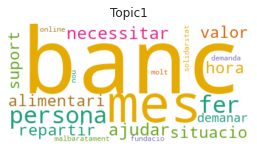

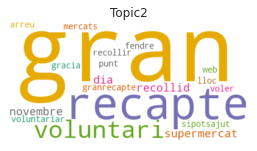

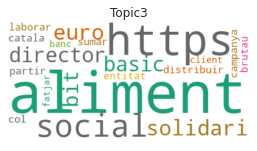

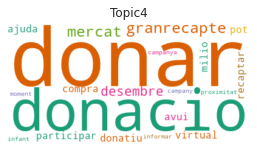

In [ ]:
##Creating wordclouds per topic for nicer presentation
# import wordclouds
from wordcloud import WordCloud

# initiate wordcloud object
wc = WordCloud(background_color="white", colormap="Dark2", max_font_size=150, random_state=42)

# set the figure size
plt.rcParams['figure.figsize'] = [20, 15]

# Create subplots for each topic
for i in range(len(topics_df)):

    wc.generate(text=topics_df["Terms per Topic"][i])
    
    plt.subplot(5, 4, i+1)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(topics_df.index[i])
    plt.show()

In [ ]:
!pip install pyLDAvis
import pyLDAvis

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_lda.py:29: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  EPS = np.finfo(np.float).eps


In [ ]:
#Converting LDA to gensim model
from gensim.models.ldamodel import LdaModel

def convertldaMalletToldaGen(mallet_model):
    model_gensim = LdaModel(
        id2word=mallet_model.id2word, num_topics=mallet_model.num_topics,
        alpha=mallet_model.alpha) 
    model_gensim.state.sstats[...] = mallet_model.wordtopics
    model_gensim.sync_state()
    return model_gensim

In [ ]:
ldagensim = convertldaMalletToldaGen(ldamallet)

In [ ]:
#Visualizing
import pyLDAvis.gensim_models as gensimvis

vis_data = gensimvis.prepare(ldagensim, corpus, id2word, sort_topics=False)
pyLDAvis.display(vis_data)

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


In [ ]:
fb_incl_topic = pd.concat([fb_data_orig, corpus_topic_df], axis=1)
fb_incl_topic.to_csv('/content/Fb_incl_topic.csv')

##Instagram

In [ ]:
##NLP Instagram
#Importing Insta data
insta_data_orig = pd.read_csv('/content/insta_labeled (1).csv')
insta_data_orig['post_id'] = [i for i in range(1,(len(insta_data_orig)+1))]

In [ ]:
#Removing NaNs
insta_data_nlp = insta_data_orig.dropna(subset=['Subtitle'])

In [ ]:
data = list(insta_data_nlp.Subtitle)

In [ ]:
#Creating bigrams for preprocessing
bigram = gensim.models.Phrases(data)
trigram = gensim.models.Phrases(bigram[data], threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [ ]:
data_ready = process_words(data)

In [ ]:
#Creating dictionary for corpus later
id2word = corpora.Dictionary(data_ready)
print('Total Vocabulary Size:', len(id2word))

Total Vocabulary Size: 541


In [ ]:
#Creating corpus of words
corpus = [id2word.doc2bow(text) for text in data_ready]

In [ ]:
#Creating dictionary to check word frequencies
dict_corpus = {}

for i in range(len(corpus)):
  for idx, freq in corpus[i]:
    if id2word[idx] in dict_corpus:
      dict_corpus[id2word[idx]] += freq
    else:
       dict_corpus[id2word[idx]] = freq
       
dict_df = pd.DataFrame.from_dict(dict_corpus, orient='index', columns=['freq'])

In [ ]:
#Top 10 most used words on Instagram captions
dict_df.sort_values('freq', ascending=False).head(10)

,freq
aliment,61
mes,35
granrecapte,28
banc,24
donar,21
gran,18
ajudar,17
voluntari,17
persona,17
ajuda,16


In [ ]:
#Building model
mallet_path = '/content/mallet-2.0.8/bin/mallet'

In [ ]:
#Defining model with top 4 topics 
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=4, id2word=id2word)

/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)


In [ ]:
#Display topics
pprint(ldamallet.show_topics(formatted=False))

[(0,
  [('gran', 0.056074766355140186),
   ('voluntari', 0.0529595015576324),
   ('ajudar', 0.0529595015576324),
   ('persona', 0.04984423676012461),
   ('donacio', 0.040498442367601244),
   ('recapte', 0.037383177570093455),
   ('solidaritat', 0.024922118380062305),
   ('difon', 0.018691588785046728),
   ('causar', 0.018691588785046728),
   ('basic', 0.01557632398753894)]),
 (1,
  [('aliment', 0.18263473053892215),
   ('banc', 0.0718562874251497),
   ('sms', 0.029940119760479042),
   ('mai', 0.023952095808383235),
   ('primer', 0.020958083832335328),
   ('families', 0.020958083832335328),
   ('crisi', 0.017964071856287425),
   ('dona', 0.017964071856287425),
   ('donatiu', 0.017964071856287425),
   ('enviar', 0.014970059880239521)]),
 (2,
  [('granrecapte', 0.08333333333333333),
   ('dia', 0.03869047619047619),
   ('fer', 0.03869047619047619),
   ('necessitar', 0.03273809523809524),
   ('novembre', 0.03273809523809524),
   ('sipotsajut', 0.03273809523809524),
   ('supermercat', 0.0267

In [ ]:
#Getting topic modeling results by passing in corpus in model
tm_results = ldamallet[corpus]
#Getting dominant topic for each post
corpus_topics = [sorted(topics, key=lambda record: -record[1])[0] for topics in tm_results]

/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)


In [ ]:
#Showing topics in df
topics = [[(term, round(wt, 3)) for term, wt in ldamallet.show_topic(n, topn=20)] for n in range(0, ldamallet.num_topics)]
topics_df = pd.DataFrame([[term for term, wt in topic] for topic in topics], columns = ['Term'+str(i) for i in range(1, 21)], index=['Topic '+str(t) for t in range(1, ldamallet.num_topics+1)]).T
topics_df.head()

,Topic 1,Topic 2,Topic 3,Topic 4
Term1,gran,aliment,granrecapte,mes
Term2,voluntari,banc,dia,donar
Term3,ajudar,sms,fer,ajuda
Term4,persona,mai,novembre,www
Term5,donacio,primer,sipotsajut,https


In [ ]:
#change column width
pd.set_option('display.max_colwidth', -1)
topics_df = pd.DataFrame([', '.join([term for term, wt in topic]) for topic in topics], columns = ['Terms per Topic'], index=['Topic'+str(t) for t in range(1, ldamallet.num_topics+1)] )
topics_df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


,Terms per Topic
Topic1,"gran, voluntari, ajudar, persona, donacio, recapte, solidaritat, difon, causar, basic, objectiu, punt, entorn, aconseguir, agreujat, informacio, oferir, vostr, fre, adquirir"
Topic2,"aliment, banc, sms, mai, primer, families, crisi, donatiu, dona, enviar, situacio, important, favor, alimento, paraula, ara, milio, emergencia, vulnerabl, proper"
Topic3,"granrecapte, dia, fer, novembre, sipotsajut, necessitar, supermercat, pot, solidari, enguany, gracia, recollid, avui, laborar, campanya, seguir, virtual, bizum, caixa, informar"
Topic4,"mes, donar, ajuda, www, https, social, euro, fendre, compra, participar, ser, impulsat, demanda, ayut, producte, coronavirus, web, fundlacaixa, augmentar, alimentacio"


In [ ]:
#Dominant topics for each article (to add in xlsx)
# create a dataframe
corpus_topic_df = pd.DataFrame()
# get the Titles from the original dataframe
corpus_topic_df['post_id'] = insta_data_nlp.post_id
corpus_topic_df['Dominant Topic'] = [item[0]+1 for item in corpus_topics]
corpus_topic_df['Contribution %'] = [round(item[1]*100, 2) for item in corpus_topics]
corpus_topic_df['Topic Terms'] = [topics_df.iloc[t[0]]['Terms per Topic'] for t in corpus_topics]
corpus_topic_df.head()

,post_id,Dominant Topic,Contribution %,Topic Terms
0,1,2,27.88,"aliment, banc, sms, mai, primer, families, crisi, donatiu, dona, enviar, situacio, important, favor, alimento, paraula, ara, milio, emergencia, vulnerabl, proper"
1,2,2,29.42,"aliment, banc, sms, mai, primer, families, crisi, donatiu, dona, enviar, situacio, important, favor, alimento, paraula, ara, milio, emergencia, vulnerabl, proper"
2,3,2,26.59,"aliment, banc, sms, mai, primer, families, crisi, donatiu, dona, enviar, situacio, important, favor, alimento, paraula, ara, milio, emergencia, vulnerabl, proper"
3,4,2,31.45,"aliment, banc, sms, mai, primer, families, crisi, donatiu, dona, enviar, situacio, important, favor, alimento, paraula, ara, milio, emergencia, vulnerabl, proper"
4,5,4,31.57,"mes, donar, ajuda, www, https, social, euro, fendre, compra, participar, ser, impulsat, demanda, ayut, producte, coronavirus, web, fundlacaixa, augmentar, alimentacio"


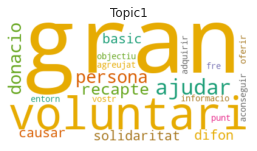

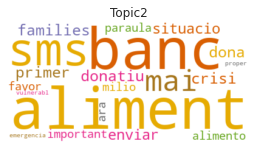

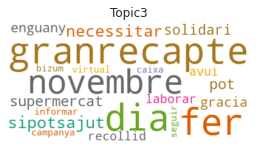

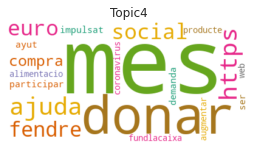

In [ ]:
##Creating wordclouds per topic for better presentation

# import wordclouds
from wordcloud import WordCloud

# initiate wordcloud object
wc = WordCloud(background_color="white", colormap="Dark2", max_font_size=150, random_state=42)

# set the figure size
plt.rcParams['figure.figsize'] = [20, 15]

# Create subplots for each topic
for i in range(len(topics_df)):

    wc.generate(text=topics_df["Terms per Topic"][i])
    
    plt.subplot(5, 4, i+1)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(topics_df.index[i])
    plt.show()

In [ ]:
ldagensim = convertldaMalletToldaGen(ldamallet)

In [ ]:
#Visualizing
vis_data = gensimvis.prepare(ldagensim, corpus, id2word, sort_topics=False)
pyLDAvis.display(vis_data)

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


In [ ]:
#Joining datasets
insta_incl_topic = pd.concat([insta_data_orig, corpus_topic_df], axis=1)

#Downloading new dataset
insta_incl_topic.to_csv('/content/insta_incl_topic.csv')

##Twitter

In [ ]:
##NLP Twitter
#Importing Twitter data
twit_data_orig = pd.read_csv('/content/twit_labeled.csv')
twit_data_orig['post_id'] = [i for i in range(1,(len(twit_data_orig)+1))]
twit_data_orig.rename(columns = {'Tweet tekst':'tweet_text'}, inplace = True)

In [ ]:
#Removing blank tweets
twit_data_nlp = twit_data_orig.dropna(subset=['tweet_text'])

In [ ]:
data = list(twit_data_nlp.tweet_text)

In [ ]:
#Creating bigrams for preprocessing
bigram = gensim.models.Phrases(data)
trigram = gensim.models.Phrases(bigram[data], threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [ ]:
data_ready = process_words(data)

In [ ]:
#Creating dictionary for corpus later
id2word = corpora.Dictionary(data_ready)
print('Total Vocabulary Size:', len(id2word))

Total Vocabulary Size: 1194


In [ ]:
#Creating corpus of words
corpus = [id2word.doc2bow(text) for text in data_ready]

#Creating dictionary to check word frequencies
dict_corpus = {}

for i in range(len(corpus)):
  for idx, freq in corpus[i]:
    if id2word[idx] in dict_corpus:
      dict_corpus[id2word[idx]] += freq
    else:
       dict_corpus[id2word[idx]] = freq
       
dict_df = pd.DataFrame.from_dict(dict_corpus, orient='index', columns=['freq'])
#Top 10 most used words on Instagram captions
dict_df.sort_values('freq', ascending=False).head(10)

,freq
https,200
aliment,168
banc,87
mes,74
persona,46
donar,33
labor,30
ajuda,30
dia,29
fer,27


In [ ]:
# Filter out words that occur less than 2 documents, or more than 80% of the documents.
id2word.filter_extremes(no_below=2, no_above=0.8)
print('Total Vocabulary Size:', len(id2word))

Total Vocabulary Size: 442


In [ ]:
#Creating corpus of words
corpus = [id2word.doc2bow(text) for text in data_ready]

#Creating dictionary to check word frequencies
dict_corpus = {}

for i in range(len(corpus)):
  for idx, freq in corpus[i]:
    if id2word[idx] in dict_corpus:
      dict_corpus[id2word[idx]] += freq
    else:
       dict_corpus[id2word[idx]] = freq
       
dict_df = pd.DataFrame.from_dict(dict_corpus, orient='index', columns=['freq'])
#Top 10 most used words on Instagram captions after filter
dict_df.sort_values('freq', ascending=False).head(10)

,freq
https,200
aliment,168
banc,87
mes,74
persona,46
donar,33
ajuda,30
labor,30
dia,29
fer,27


In [ ]:
#Building model
mallet_path = '/content/mallet-2.0.8/bin/mallet'

In [ ]:
#Defining model with top 5 topics 
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=5, id2word=id2word)

/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)


In [ ]:
#Display topics
pprint(ldamallet.show_topics(formatted=True))

[(0,
  '0.065*"donar" + 0.049*"social" + 0.043*"donacio" + 0.041*"voluntari" + '
  '0.035*"entitat" + 0.029*"granrecapte" + 0.027*"fer" + 0.025*"avui" + '
  '0.025*"gran" + 0.024*"daur"'),
 (1,
  '0.383*"https" + 0.052*"dia" + 0.034*"gracia" + 0.025*"primer" + '
  '0.023*"solidari" + 0.017*"pued" + 0.013*"sumar" + 0.013*"ates" + '
  '0.013*"basic" + 0.013*"bizum"'),
 (2,
  '0.236*"aliment" + 0.159*"banc" + 0.026*"euro" + 0.024*"fer" + '
  '0.022*"seguir" + 0.018*"campanya" + 0.018*"magatzem" + 0.015*"arribar" + '
  '0.015*"internacional" + 0.013*"impulsat"'),
 (3,
  '0.081*"aliment" + 0.062*"ajuda" + 0.052*"ajudar" + 0.039*"sms" + '
  '0.035*"fundlacaixacat" + 0.035*"dona" + 0.031*"crisi" + 0.025*"families" + '
  '0.023*"enviar" + 0.021*"situacio"'),
 (4,
  '0.143*"mes" + 0.089*"persona" + 0.054*"labor" + 0.043*"necessitar" + '
  '0.039*"vacanca" + 0.035*"quilo" + 0.035*"milio" + 0.031*"estiu" + '
  '0.031*"alimentacio" + 0.027*"fam"')]


In [ ]:
#Getting topic modeling results by passing in corpus in model
tm_results = ldamallet[corpus]
#Getting dominant topic for each post
corpus_topics = [sorted(topics, key=lambda record: -record[1])[0] for topics in tm_results]

/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)


In [ ]:
#Showing topics in df
topics = [[(term, round(wt, 3)) for term, wt in ldamallet.show_topic(n, topn=20)] for n in range(0, ldamallet.num_topics)]
topics_df = pd.DataFrame([[term for term, wt in topic] for topic in topics], columns = ['Term'+str(i) for i in range(1, 21)], index=['Topic '+str(t) for t in range(1, ldamallet.num_topics+1)]).T
topics_df.head()

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
Term1,donar,https,aliment,aliment,mes
Term2,social,dia,banc,ajuda,persona
Term3,donacio,gracia,euro,ajudar,labor
Term4,voluntari,primer,fer,sms,necessitar
Term5,entitat,solidari,seguir,dona,vacanca


In [ ]:
#change column width
pd.set_option('display.max_colwidth', -1)
topics_df = pd.DataFrame([', '.join([term for term, wt in topic]) for topic in topics], columns = ['Terms per Topic'], index=['Topic'+str(t) for t in range(1, ldamallet.num_topics+1)] )
topics_df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


,Terms per Topic
Topic1,"donar, social, donacio, voluntari, entitat, granrecapte, fer, avui, gran, alimentari, daur, abans, recapte, supermercat, recollid, novembre, fendre, participar, inici, continuar"
Topic2,"https, dia, gracia, primer, solidari, pued, bizum, ates, basic, sumar, producte, aliments, avui, ayre, tmnub, playmobil, virus, coordinar, donant, puede"
Topic3,"aliment, banc, euro, fer, seguir, campanya, magatzem, arribar, internacional, marxar, impulsat, infantil, compra, taula, favor, necessitat, llegum, moment, sector, recollir"
Topic4,"aliment, ajuda, ajudar, sms, dona, fundlacaixacat, crisi, families, enviar, situacio, alimento, paraula, coronaviru, ara, mai, aquar, solidaritat, web, activitat, director"
Topic5,"mes, persona, labor, necessitar, vacanca, quilo, milio, alimentacio, estiu, fam, col, contribuir, garantir, malbaratament, catala, millo, distribuits, emergencia, celebrar, colar"


In [ ]:
#Dominant topics for each article (to add in xlsx)
# create a dataframe
corpus_topic_df = pd.DataFrame()
# get the Titles from the original dataframe
corpus_topic_df['post_id'] = twit_data_nlp.post_id
corpus_topic_df['Dominant Topic'] = [item[0]+1 for item in corpus_topics]
corpus_topic_df['Contribution %'] = [round(item[1]*100, 2) for item in corpus_topics]
corpus_topic_df['Topic Terms'] = [topics_df.iloc[t[0]]['Terms per Topic'] for t in corpus_topics]
corpus_topic_df.head()

,post_id,Dominant Topic,Contribution %,Topic Terms
0,1,3,22.22,"aliment, banc, euro, fer, seguir, campanya, magatzem, arribar, internacional, marxar, impulsat, infantil, compra, taula, favor, necessitat, llegum, moment, sector, recollir"
1,2,2,22.81,"https, dia, gracia, primer, solidari, pued, bizum, ates, basic, sumar, producte, aliments, avui, ayre, tmnub, playmobil, virus, coordinar, donant, puede"
2,3,3,26.41,"aliment, banc, euro, fer, seguir, campanya, magatzem, arribar, internacional, marxar, impulsat, infantil, compra, taula, favor, necessitat, llegum, moment, sector, recollir"
3,4,2,22.22,"https, dia, gracia, primer, solidari, pued, bizum, ates, basic, sumar, producte, aliments, avui, ayre, tmnub, playmobil, virus, coordinar, donant, puede"
4,5,2,23.15,"https, dia, gracia, primer, solidari, pued, bizum, ates, basic, sumar, producte, aliments, avui, ayre, tmnub, playmobil, virus, coordinar, donant, puede"


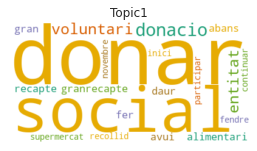

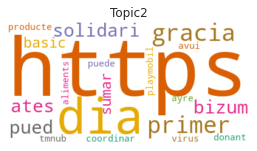

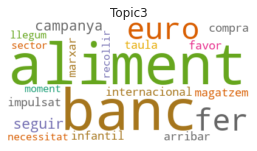

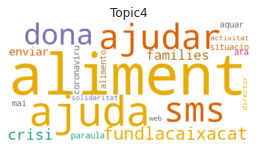

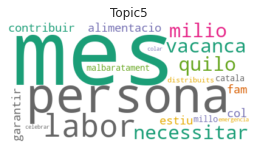

In [ ]:
##Creating wordclouds per topic for better presentation

# import wordclouds
from wordcloud import WordCloud

# initiate wordcloud object
wc = WordCloud(background_color="white", colormap="Dark2", max_font_size=150, random_state=42)

# set the figure size
plt.rcParams['figure.figsize'] = [20, 15]

# Create subplots for each topic
for i in range(len(topics_df)):

    wc.generate(text=topics_df["Terms per Topic"][i])
    
    plt.subplot(5, 4, i+1)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(topics_df.index[i])
    plt.show()

In [ ]:
ldagensim = convertldaMalletToldaGen(ldamallet)

In [ ]:
#Visualizing
vis_data = gensimvis.prepare(ldagensim, corpus, id2word, sort_topics=False)
pyLDAvis.display(vis_data)

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


In [ ]:
#Joining datasets
twit_incl_topic = pd.concat([twit_data_orig, corpus_topic_df], axis=1)

#Downloading new dataset
twit_incl_topic.to_csv('/content/twit_incl_topic.csv')